In [1]:
import numpy as np
import time
import os
import cv2
import sys

In [2]:
# we can easily adjust the input and network parameter sizes
# Input: (48,80), (96, 160), (144, 240), (192, 320)
# Try to only changing the dense layer parameter number 
# Also try creating more conv layers so that the compressed format is same parameters




In [3]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

In [4]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X_c, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X_c, length_per_mvi)

print("Total time to load small-data is", time.time() - start_time, "seconds")

  0%|          | 3/10421 [00:00<06:01, 28.84it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [03:57<00:00, 43.93it/s]
1it [00:00,  2.91it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  2.82it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:00,  3.52it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  3.23it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:01,  2.77it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:02,  2.78it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  2.89it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


9it [00:02,  2.82it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821


10it [00:03,  3.19it/s]

MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.38it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:03,  2.63it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.16it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
Total time to load small-data is 241.8646194934845 seconds


In [5]:
# Divide the data into train, test

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

Xc_train, Xc_test, Y_train_dict, Y_test_dict = _split_train_test(X_c, Y_dict)

In [6]:
# Now cluster the data

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

Populating the interactive namespace from numpy and matplotlib


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


(540, 960, 3)
(540, 960, 3)


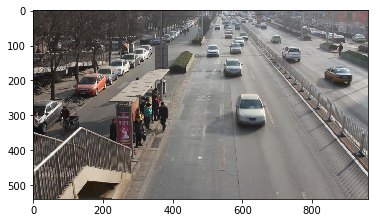

In [7]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(Xc_train[image_index].shape)

example = Xc_train[image_index]
print(example.shape)

plt.imshow(example)

In [33]:
# Must perform normalization for the autoencoder to perform well
Xc_train_norm = np.copy(Xc_train)
Xc_test_norm = np.copy(Xc_test)


def _reform_input(image_table, height, width, grayscale = True):
    # This function could rapidly change according to what we want
    # But the purpose of this function is to feed in the input as per network specifications
    # current specs: convert to size (48, 80) and grayscale

    start_time = time.time()
    assert(len(image_table.shape) == 4)
    n_samples = image_table.shape[0]
    channels = 3
    if grayscale:
        channels = 1
    
    image_array = np.ndarray(shape=(n_samples, height, width, channels))
        
    for i in range(len(image_table)):
        image = image_table[i ,: ,: ,:]
        if grayscale:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
        image = cv2.resize(image, (width, height))
        # might need to expand dimension
        if grayscale:
            image_array[i ,: ,: ,0] = image
        else:
            image_array[i,:,:,:] = image
        
    image_array /= 255.0  # normalize the input for layers
    print("finished reforming input, total time taken is", time.time() - start_time, "seconds")
    return image_array

#size_array = [(48,80), (96, 160), (144, 240), (192, 320)]
size_array = [(48, 80), (48,80), (48, 80)]
X_train_norm_arr = []
X_test_norm_arr = []
for i in range(len(size_array)):
    height, width = size_array[i]
    X_train_norm_arr.append(_reform_input(Xc_train_norm, height, width, grayscale = False))
    X_test_norm_arr.append(_reform_input(Xc_test_norm, height, width, grayscale = False))



finished reforming input, total time taken is 1.5289702415466309 seconds
finished reforming input, total time taken is 0.3075098991394043 seconds
finished reforming input, total time taken is 1.5237627029418945 seconds
finished reforming input, total time taken is 0.3133203983306885 seconds
finished reforming input, total time taken is 1.2689878940582275 seconds
finished reforming input, total time taken is 0.32688021659851074 seconds


In [34]:

keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [35]:
# Combined network with both FC and CNN layers

# Input
def build(X_train, layer_num):
    n_samples, width, height, channels = X_train.shape
    
    input_img = Input(shape=(width, height, channels))
    #48x80x3
    # Encoder
    x = input_img
    for i in range(layer_num):
        x = Conv2D(8*(i+1),(3,3),
                   activation='relu',
                   padding='same')(x)
        x = Conv2D(8*(i+1),(3,3),
                   activation='relu',
                   padding='same')(x)
        x = MaxPooling2D((2,2),
                     padding='same')(x)
        #layer_num = 3
        #24x40x8
        #12x20x16
        #6x10x24
    
    x = Flatten()(x)
    encoded = Dense(256)(x)
    # Decoder
    x = Dense(int(height / (2**layer_num) * width / (2**layer_num) * 8 * layer_num))(encoded)
    print(int(width / (2**layer_num)), int(height / (2**layer_num)), 8*layer_num)
    x = Reshape((int(width / (2**layer_num)), int(height / (2**layer_num)),  8*layer_num))(x)
    
    for i in range(layer_num):
        x = UpSampling2D((2, 2))(x) # 24, 40, 16
        x = Conv2D(8*(layer_num - i), (3, 3),
                   activation='relu',
                   padding='same')(x)
        x = Conv2D(8*(layer_num - i), (3, 3),
                   activation='relu',
                   padding='same')(x)
        
    decoded = Conv2D(channels, (3, 3),
               activation='relu',
               padding='same')(x)

    autoencoder = Model(input_img, decoded)

    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.summary()
    return encoder, autoencoder

encoder_arr = []
autoencoder_arr = []

for i in range(len(size_array)):
    print(i)
    enc, aut = build(X_train_norm_arr[i], i + 2)
    encoder_arr.append(enc)
    autoencoder_arr.append(aut)


0
12 20 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 80, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 80, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 40, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 40, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 20, 16)        0         

In [36]:
training_time_arr = []
for i in range(len(size_array)):   
    start_time = time.time()
    train_history = autoencoder_arr[i].fit(X_train_norm_arr[i], X_train_norm_arr[i], epochs=200, batch_size=2048, validation_data=(X_test_norm_arr[i], X_test_norm_arr[i]))
    print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")
    training_time_arr.append(time.time() - start_time)
    


Train on 8336 samples, validate on 2085 samples
Epoch 1/200
8336/8336 [==============================] - 5s 602us/step - loss: 0.2070 - val_loss: 0.1301
Epoch 2/200
8336/8336 [==============================] - 4s 427us/step - loss: 0.1211 - val_loss: 0.1025
Epoch 3/200
8336/8336 [==============================] - 4s 430us/step - loss: 0.0961 - val_loss: 0.0771
Epoch 4/200
8336/8336 [==============================] - 4s 438us/step - loss: 0.0693 - val_loss: 0.0522
Epoch 5/200
8336/8336 [==============================] - 4s 440us/step - loss: 0.0433 - val_loss: 0.0346
Epoch 6/200
8336/8336 [==============================] - 4s 466us/step - loss: 0.0335 - val_loss: 0.0315
Epoch 7/200
8336/8336 [==============================] - 4s 455us/step - loss: 0.0302 - val_loss: 0.0285
Epoch 8/200
8336/8336 [==============================] - 4s 470us/step - loss: 0.0277 - val_loss: 0.0271
Epoch 9/200
8336/8336 [==============================] - 4s 470us/step - loss: 0.0265 - val_loss: 0.0262
Epoch 1

Epoch 78/200
8336/8336 [==============================] - 3s 419us/step - loss: 0.0095 - val_loss: 0.0139
Epoch 79/200
8336/8336 [==============================] - 4s 428us/step - loss: 0.0094 - val_loss: 0.0138
Epoch 80/200
8336/8336 [==============================] - 4s 425us/step - loss: 0.0093 - val_loss: 0.0141
Epoch 81/200
8336/8336 [==============================] - 4s 430us/step - loss: 0.0092 - val_loss: 0.0137
Epoch 82/200
8336/8336 [==============================] - 4s 450us/step - loss: 0.0092 - val_loss: 0.0137
Epoch 83/200
8336/8336 [==============================] - 4s 423us/step - loss: 0.0091 - val_loss: 0.0137
Epoch 84/200
8336/8336 [==============================] - 4s 427us/step - loss: 0.0091 - val_loss: 0.0136
Epoch 85/200
8336/8336 [==============================] - 4s 423us/step - loss: 0.0090 - val_loss: 0.0136
Epoch 86/200
8336/8336 [==============================] - 4s 426us/step - loss: 0.0090 - val_loss: 0.0136
Epoch 87/200
8336/8336 [======================

Epoch 155/200
8336/8336 [==============================] - 4s 462us/step - loss: 0.0072 - val_loss: 0.0137
Epoch 156/200
8336/8336 [==============================] - 4s 435us/step - loss: 0.0071 - val_loss: 0.0134
Epoch 157/200
8336/8336 [==============================] - 4s 458us/step - loss: 0.0071 - val_loss: 0.0132
Epoch 158/200
8336/8336 [==============================] - 4s 439us/step - loss: 0.0070 - val_loss: 0.0130
Epoch 159/200
8336/8336 [==============================] - 4s 420us/step - loss: 0.0071 - val_loss: 0.0133
Epoch 160/200
8336/8336 [==============================] - 4s 434us/step - loss: 0.0070 - val_loss: 0.0134
Epoch 161/200
8336/8336 [==============================] - 4s 426us/step - loss: 0.0070 - val_loss: 0.0133
Epoch 162/200
8336/8336 [==============================] - 4s 436us/step - loss: 0.0070 - val_loss: 0.0129
Epoch 163/200
8336/8336 [==============================] - 4s 443us/step - loss: 0.0071 - val_loss: 0.0135
Epoch 164/200
8336/8336 [============

Epoch 31/200
8336/8336 [==============================] - 4s 444us/step - loss: 0.0214 - val_loss: 0.0216
Epoch 32/200
8336/8336 [==============================] - 4s 435us/step - loss: 0.0208 - val_loss: 0.0209
Epoch 33/200
8336/8336 [==============================] - 4s 438us/step - loss: 0.0204 - val_loss: 0.0206
Epoch 34/200
8336/8336 [==============================] - 4s 442us/step - loss: 0.0201 - val_loss: 0.0206
Epoch 35/200
8336/8336 [==============================] - 4s 454us/step - loss: 0.0197 - val_loss: 0.0203
Epoch 36/200
8336/8336 [==============================] - 4s 450us/step - loss: 0.0192 - val_loss: 0.0200
Epoch 37/200
8336/8336 [==============================] - 4s 436us/step - loss: 0.0187 - val_loss: 0.0199
Epoch 38/200
8336/8336 [==============================] - 4s 440us/step - loss: 0.0183 - val_loss: 0.0191
Epoch 39/200
8336/8336 [==============================] - 4s 438us/step - loss: 0.0177 - val_loss: 0.0186
Epoch 40/200
8336/8336 [======================

8336/8336 [==============================] - 3s 407us/step - loss: 0.0107 - val_loss: 0.0141
Epoch 109/200
8336/8336 [==============================] - 3s 400us/step - loss: 0.0111 - val_loss: 0.0140
Epoch 110/200
8336/8336 [==============================] - 3s 420us/step - loss: 0.0108 - val_loss: 0.0141
Epoch 111/200
8336/8336 [==============================] - 4s 432us/step - loss: 0.0107 - val_loss: 0.0140
Epoch 112/200
8336/8336 [==============================] - 4s 460us/step - loss: 0.0106 - val_loss: 0.0141
Epoch 113/200
8336/8336 [==============================] - 4s 472us/step - loss: 0.0106 - val_loss: 0.0141
Epoch 114/200
8336/8336 [==============================] - 4s 458us/step - loss: 0.0106 - val_loss: 0.0140
Epoch 115/200
8336/8336 [==============================] - 4s 448us/step - loss: 0.0106 - val_loss: 0.0139
Epoch 116/200
8336/8336 [==============================] - 4s 471us/step - loss: 0.0105 - val_loss: 0.0139
Epoch 117/200
8336/8336 [==========================

8336/8336 [==============================] - 4s 441us/step - loss: 0.0093 - val_loss: 0.0135
Epoch 185/200
8336/8336 [==============================] - 4s 436us/step - loss: 0.0093 - val_loss: 0.0135
Epoch 186/200
8336/8336 [==============================] - 4s 451us/step - loss: 0.0092 - val_loss: 0.0135
Epoch 187/200
8336/8336 [==============================] - 4s 462us/step - loss: 0.0092 - val_loss: 0.0135
Epoch 188/200
8336/8336 [==============================] - 4s 441us/step - loss: 0.0092 - val_loss: 0.0135
Epoch 189/200
8336/8336 [==============================] - 4s 443us/step - loss: 0.0092 - val_loss: 0.0135
Epoch 190/200
8336/8336 [==============================] - 4s 437us/step - loss: 0.0092 - val_loss: 0.0135
Epoch 191/200
8336/8336 [==============================] - 4s 445us/step - loss: 0.0092 - val_loss: 0.0136
Epoch 192/200
8336/8336 [==============================] - 4s 458us/step - loss: 0.0092 - val_loss: 0.0135
Epoch 193/200
8336/8336 [==========================

8336/8336 [==============================] - 4s 462us/step - loss: 0.0156 - val_loss: 0.0175
Epoch 61/200
8336/8336 [==============================] - 4s 444us/step - loss: 0.0154 - val_loss: 0.0173
Epoch 62/200
8336/8336 [==============================] - 4s 434us/step - loss: 0.0153 - val_loss: 0.0170
Epoch 63/200
8336/8336 [==============================] - 4s 440us/step - loss: 0.0150 - val_loss: 0.0171
Epoch 64/200
8336/8336 [==============================] - 4s 436us/step - loss: 0.0149 - val_loss: 0.0169
Epoch 65/200
8336/8336 [==============================] - 4s 453us/step - loss: 0.0148 - val_loss: 0.0168
Epoch 66/200
8336/8336 [==============================] - 4s 470us/step - loss: 0.0147 - val_loss: 0.0168
Epoch 67/200
8336/8336 [==============================] - 4s 444us/step - loss: 0.0145 - val_loss: 0.0167
Epoch 68/200
8336/8336 [==============================] - 4s 437us/step - loss: 0.0144 - val_loss: 0.0167
Epoch 69/200
8336/8336 [==============================] - 4

8336/8336 [==============================] - 4s 438us/step - loss: 0.0116 - val_loss: 0.0157
Epoch 138/200
8336/8336 [==============================] - 4s 450us/step - loss: 0.0115 - val_loss: 0.0156
Epoch 139/200
8336/8336 [==============================] - 4s 462us/step - loss: 0.0115 - val_loss: 0.0156
Epoch 140/200
8336/8336 [==============================] - 4s 447us/step - loss: 0.0115 - val_loss: 0.0156
Epoch 141/200
8336/8336 [==============================] - 4s 433us/step - loss: 0.0115 - val_loss: 0.0157
Epoch 142/200
8336/8336 [==============================] - 4s 446us/step - loss: 0.0123 - val_loss: 0.0158
Epoch 143/200
8336/8336 [==============================] - 4s 441us/step - loss: 0.0118 - val_loss: 0.0157
Epoch 144/200
8336/8336 [==============================] - 4s 452us/step - loss: 0.0116 - val_loss: 0.0158
Epoch 145/200
8336/8336 [==============================] - 4s 469us/step - loss: 0.0116 - val_loss: 0.0156
Epoch 146/200
8336/8336 [==========================

In [37]:
# After downsizing the images, we need to cluster them by similarity
# Heuristic we will use is to assume fps rate is 20. We will make num_samples / 20 clusters

# Apply hierarchical clustering
# Remember the indexes
# Put the images into correct locations
# TODO: Currently the images are not being divided correctly... We need to find out why

from sklearn.cluster import AgglomerativeClustering

#image_table_flattened = image_table.reshape(-1, width*height).astype('float32')
#image_table /= 255.0
def cluster(X_train_norm, X_test_norm, encoder):
    start_time = time.time()
    X_train_compressed = encoder.predict(X_train_norm)
    X_test_compressed = encoder.predict(X_test_norm)
    
    fps = 20
    ac = AgglomerativeClustering(n_clusters=len(X_train_compressed) // fps)
    ac1 = AgglomerativeClustering(n_clusters=len(X_test_compressed) // fps)

    ac.fit(X_train_compressed)
    X_train_clusters = ac.labels_

    ac1.fit(X_test_compressed)
    X_test_clusters = ac1.labels_


    print(min(X_train_clusters))
    print(max(X_train_clusters))
    print(min(X_test_clusters))
    print(max(X_test_clusters))
    

    return X_train_clusters, X_test_clusters, time.time() - start_time
X_train_clusters_arr = []
X_test_clusters_arr = []

for i in range(len(size_array)):
    X_train_clusters, X_test_clusters, training_time = cluster(X_train_norm_arr[i], X_test_norm_arr[i], encoder_arr[i])
    X_train_clusters_arr.append(X_train_clusters)
    X_test_clusters_arr.append(X_test_clusters)
    training_time_arr.append(training_time)


0
415
0
103
0
415
0
103
0
415
0
103


In [38]:
# Choose representative frames from each cluster
# Create a fake X_train, Y_train, X_val, Y_val for retraining the filters

# We have X_train, X_train_clusters (this gives cluster numbers), Y_train, Y_names
def pick_frames(X_train, X_test, X_train_clusters, X_test_clusters, Y_train_dict, Y_test_dict, grayscale = True):
    visited_cluster_nums = set()

    n_samples, width1, height1, _ = X_train.shape
    n_samples, width2, height2, _ = X_test.shape
    if grayscale:
        X_train_rep = np.zeros(shape = (max(X_train_clusters)+1, width1, height1, 1))
        X_test_rep = np.zeros(shape = (max(X_test_clusters)+1, width2, height2, 1))
    else:
        X_train_rep = np.zeros(shape = (max(X_train_clusters)+1, width1, height1, 3))
        X_test_rep = np.zeros(shape = (max(X_test_clusters)+1, width2, height2, 3))
    Y_train_dict_rep = {}
    Y_test_dict_rep = {}
    #Y_test_rep = np.zeros(shape = (max(X_test_clusters)+1, len(Y_names)))

    import copy
    categories = ['vehicle_type', 'color', 'speed', 'intersection']
    for category in categories:
        Y_train_dict_rep[category] = [None] * (max(X_train_clusters)+1)
        Y_test_dict_rep[category] = [None] * (max(X_test_clusters) + 1)
        
    assert(len(X_train_clusters) == len(X_train))
    assert(len(X_test_clusters) == len(X_test))
    
    for i in range(len(X_train_clusters)):
        if X_train_clusters[i] not in visited_cluster_nums:
            visited_cluster_nums.add(X_train_clusters[i])
            # we want to pick these frames out but we need to remember their index so that we can extract their labels
            # cluster number will be their index
            assert(len(X_train.shape) == 4)
            if grayscale:
                X_train_rep[X_train_clusters[i],:,:,:] = X_train[i,:,:,:]
            for category in categories:
                Y_train_dict_rep[category][X_train_clusters[i]] = copy.deepcopy(Y_train_dict[category][i])

    visited_cluster_nums.clear()

    for i in range(len(X_test_clusters)):
        if X_test_clusters[i] not in visited_cluster_nums:
            visited_cluster_nums.add(X_test_clusters[i])
            # we want to pick these frames out but we need to remember their index so that we can extract their labels
            # cluster number will be their index
            assert(len(X_test.shape) == 4)
            X_test_rep[X_test_clusters[i],:,:,:] = X_test[i,:,:,:]
            for category in categories:
                Y_test_dict_rep[category][X_test_clusters[i]] = copy.deepcopy(Y_test_dict[category][i])


    print(X_train_rep.shape)
    print(X_test_rep.shape)
    
    return X_train_rep, X_test_rep, Y_train_dict_rep, Y_test_dict_rep

X_train_rep_arr = []
X_test_rep_arr = []
Y_train_dict_rep_arr = []
Y_test_dict_rep_arr = []

for i in range(len(size_array)):
    X_train_rep, X_test_rep, Y_train_dict_rep, Y_test_dict_rep = \
        pick_frames(X_train_norm_arr[i], X_test_norm_arr[i], X_train_clusters_arr[i], X_test_clusters_arr[i], Y_train_dict, Y_test_dict, grayscale = False)
    X_train_rep_arr.append(X_train_rep)
    X_test_rep_arr.append(X_test_rep)
    Y_train_dict_rep_arr.append(Y_train_dict_rep)
    Y_test_dict_rep_arr.append(Y_test_dict_rep)

    

(416, 48, 80, 3)
(104, 48, 80, 3)
(416, 48, 80, 3)
(104, 48, 80, 3)
(416, 48, 80, 3)
(104, 48, 80, 3)


In [39]:
# Train the filters
from filters.pp import PP

def train_rep_filters(X_train_rep, Y_train_dict_rep):
    pp_rep = PP()
    start_time = time.time()
    pp_rep.train(X_train_rep, Y_train_dict_rep)
    print("Total time to train all columns all models ", time.time() - start_time, "seconds")
    return pp_rep

pp_rep_arr = []

for i in range(len(size_array)):
    pp_rep = train_rep_filters(X_train_rep_arr[i], Y_train_dict_rep_arr[i])
    pp_rep_arr.append(pp_rep)


Generating binary labels...
(416, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60', 's<65', 's<70', 'i=pt335', 'i=pt211', 'i=pt342', 'i=pt208', 'o=pt335', 'o=pt211', 'o=pt342', 'o=pt208']
[[1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Done in 0.02847743034362793 seconds
reshaping images...
before: (416, 48, 80, 3)
After cha

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/decomposition/pca.py:446: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


dnn finished training for column s<70 in 0.01065683364868164 seconds
dnn finished training for column i=pt335 in 0.004886627197265625 seconds
dnn finished training for column i=pt211 in 0.007063150405883789 seconds
dnn finished training for column i=pt342 in 0.004859447479248047 seconds
dnn finished training for column i=pt208 in 0.004862546920776367 seconds
dnn finished training for column o=pt335 in 0.004276752471923828 seconds
dnn finished training for column o=pt211 in 0.004297494888305664 seconds
dnn finished training for column o=pt342 in 0.004641532897949219 seconds
dnn finished training for column o=pt208 in 0.004403352737426758 seconds
Full Model Name: pca_rf using pca'd X_train
rf finished training for column t=car in 0.017250776290893555 seconds
rf finished training for column t=van in 0.016717195510864258 seconds
rf finished training for column t=bus in 0.015671253204345703 seconds
rf finished training for column t=others in 0.015689373016357422 seconds
rf finished training

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

rf finished training for column s>60 in 0.013773679733276367 seconds
rf finished training for column s<65 in 0.01320958137512207 seconds
rf finished training for column s<70 in 0.013453483581542969 seconds
rf finished training for column i=pt335 in 0.010822057723999023 seconds
rf finished training for column i=pt211 in 0.00843501091003418 seconds
rf finished training for column i=pt342 in 0.008298158645629883 seconds
rf finished training for column i=pt208 in 0.008292198181152344 seconds
rf finished training for column o=pt335 in 0.009030342102050781 seconds
rf finished training for column o=pt211 in 0.008337259292602539 seconds
rf finished training for column o=pt342 in 0.008405923843383789 seconds
rf finished training for column o=pt208 in 0.008574724197387695 seconds
Done in 0.49935007095336914 seconds
Total time to train all columns all models  0.5451326370239258 seconds
Generating binary labels...
(416, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

svm finished training for column s>40 in 0.01656794548034668 seconds
Training for s>50
svm finished training for column s>50 in 0.007769584655761719 seconds
Training for s>60
svm finished training for column s>60 in 0.003132343292236328 seconds
All the labels are same for column s<65
All the labels are same for column s<70
Training for i=pt335
svm finished training for column i=pt335 in 0.0029709339141845703 seconds
Training for i=pt211
svm finished training for column i=pt211 in 0.0029735565185546875 seconds
Training for i=pt342
svm finished training for column i=pt342 in 0.0033059120178222656 seconds
Training for i=pt208
svm finished training for column i=pt208 in 0.0031936168670654297 seconds
Training for o=pt335
svm finished training for column o=pt335 in 0.0032160282135009766 seconds
Training for o=pt211
svm finished training for column o=pt211 in 0.0029582977294921875 seconds
Training for o=pt342
svm finished training for column o=pt342 in 0.003308534622192383 seconds
Training fo

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

rf finished training for column s>40 in 0.017619848251342773 seconds
rf finished training for column s>50 in 0.015151262283325195 seconds
rf finished training for column s>60 in 0.013466835021972656 seconds
rf finished training for column s<65 in 0.013795137405395508 seconds
rf finished training for column s<70 in 0.012853145599365234 seconds
rf finished training for column i=pt335 in 0.009580135345458984 seconds
rf finished training for column i=pt211 in 0.008547306060791016 seconds
rf finished training for column i=pt342 in 0.008385419845581055 seconds
rf finished training for column i=pt208 in 0.008369207382202148 seconds
rf finished training for column o=pt335 in 0.008746623992919922 seconds
rf finished training for column o=pt211 in 0.008422136306762695 seconds
rf finished training for column o=pt342 in 0.008429765701293945 seconds
rf finished training for column o=pt208 in 0.008438587188720703 seconds
Done in 0.47888922691345215 seconds
Total time to train all columns all models 

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

Training for s>40
svm finished training for column s>40 in 0.011397600173950195 seconds
Training for s>50
svm finished training for column s>50 in 0.0064296722412109375 seconds
Training for s>60
svm finished training for column s>60 in 0.0031626224517822266 seconds
All the labels are same for column s<65
All the labels are same for column s<70
Training for i=pt335
svm finished training for column i=pt335 in 0.0030426979064941406 seconds
Training for i=pt211
svm finished training for column i=pt211 in 0.0031347274780273438 seconds
Training for i=pt342
svm finished training for column i=pt342 in 0.0034368038177490234 seconds
Training for i=pt208
svm finished training for column i=pt208 in 0.003246784210205078 seconds
Training for o=pt335
svm finished training for column o=pt335 in 0.003354787826538086 seconds
Training for o=pt211
svm finished training for column o=pt211 in 0.0031309127807617188 seconds
Training for o=pt342
svm finished training for column o=pt342 in 0.003440380096435547 

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

In [40]:
# Before Evaluation, we want to convert to the original test with labels with the chosen ones
# Use X_test, Y_test_adjusted for evaluation
def extend_labels(Y_test, Y_test_rep, X_test_clusters):
    n_samples, columns = Y_test.shape
    Y_test_adjusted = np.zeros(shape = (n_samples, columns))
    for i in range(len(X_test_clusters)):
        Y_test_adjusted[i,:] = Y_test_rep[X_test_clusters[i],:]
    return Y_test_adjusted

Y_names, Y_test = pp_rep_arr[0]._generate_binary_labels(Y_test_dict, len(Xc_test))
Y_test_rep_arr = []
Y_test_adjusted_arr = []

for i in range(len(size_array)):
    _, Y_test_rep = pp_rep_arr[i]._generate_binary_labels(Y_test_dict_rep_arr[i], len(Xc_test))
    Y_test_rep_arr.append(Y_test_rep)
    Y_test_adjusted = extend_labels(Y_test, Y_test_rep_arr[i], X_test_clusters_arr[i])
    Y_test_adjusted_arr.append(Y_test_adjusted)
    


(2085, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60', 's<65', 's<70', 'i=pt335', 'i=pt211', 'i=pt342', 'i=pt208', 'o=pt335', 'o=pt211', 'o=pt342', 'o=pt208']
[[1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(2085, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60',

In [41]:
# Evaluate the filters
def evaluate(pp_rep, X_test, Y_names, Y_test_adjusted):
    pca_model_rep = pp_rep.trained_pre['pca']
    trained_models_rep = pp_rep.trained_post 
    tic = time.time()
    """
    {'t=car': {'pca_svm': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=10000, probability=True, random_state=None,
      shrinking=True, tol=0.001, verbose=False),
    """
    X_test_reshaped = pp_rep._reshape_image(X_test)
    X_test_pcaed = pca_model_rep.transform(X_test_reshaped)

    stats_rep = {}
    for Y_col, models in trained_models_rep.items():
        for model_name, model in models.items():
            if 'pca' in model_name:
                index = Y_names.index(Y_col)
                #print("index is",index)
                #print(Y_test[:10][0])
                #print(type(index))
                score = model.score(X_test_pcaed, Y_test_adjusted[:, index])
                stats_rep[Y_col + " " + model_name] = [score]
            else:
                index = Y_names.index(Y_col)
                score = model.score(X_test_reshaped, Y_test_adjusted[:, index])
                stats_rep[Y_col + " " + model_name] = [score]

    print("Finished evaluation in ", time.time() - tic, "seconds")  
    return stats_rep

stats_rep_arr = []
for i in range(len(size_array)):
    stats_rep = evaluate(pp_rep_arr[i], X_test_norm_arr[i], Y_names, Y_test_adjusted_arr[i])
    stats_rep_arr.append(stats_rep)
    


before: (2085, 48, 80, 3)
After change, shape of image is (2085, 180)
Finished evaluation in  0.20353937149047852 seconds
before: (2085, 48, 80, 3)
After change, shape of image is (2085, 180)
Finished evaluation in  0.17283391952514648 seconds
before: (2085, 48, 80, 3)
After change, shape of image is (2085, 180)
Finished evaluation in  0.13207101821899414 seconds


In [42]:
# Compute the accuracy and speed

# convert stats dict to table
# rows should be column name and model
# cols should be accuracy, training_time
def convert2arr(stats_rep, pp_rep):
    stats_arr_rep = np.zeros(shape=(len(stats_rep), 2))
    row_names_rep = []
    index = 0
    for row, col in stats_rep.items():
        row_names_rep.append(row)
        stats_arr_rep[index, 0] = col[0]
        index += 1

    for Y_col, models in pp_rep.column_stats.items():
        for model_name, cost in models.items():
            row_index = row_names_rep.index(Y_col + " " + model_name)
            stats_arr_rep[row_index, 1] = cost[0]
    return stats_arr_rep, row_names_rep

stats_arr_rep_arr = []
row_names_arr = []

for i in range(len(size_array)):
    stats_arr_rep, row_names = convert2arr(stats_rep_arr[i], pp_rep_arr[i])
    stats_arr_rep_arr.append(stats_arr_rep)
    row_names_arr.append(row_names)


In [43]:
print(stats_arr_rep_arr[0])

[[0.65947242 0.02      ]
 [0.65947242 0.        ]
 [0.65947242 0.03      ]
 [0.67625899 0.02      ]
 [0.67625899 0.        ]
 [0.67625899 0.03      ]
 [0.94532374 0.01      ]
 [0.94532374 0.        ]
 [0.94532374 0.03      ]
 [0.96978417 0.02      ]
 [0.96978417 0.        ]
 [0.96978417 0.03      ]
 [0.97889688 0.02      ]
 [0.97889688 0.        ]
 [0.97889688 0.03      ]
 [0.98561151 0.02      ]
 [0.98561151 0.01      ]
 [0.98561151 0.02      ]
 [0.97553957 0.01      ]
 [0.97553957 0.        ]
 [0.97553957 0.02      ]
 [0.69496403 0.03      ]
 [0.69496403 0.        ]
 [0.69496403 0.02      ]
 [0.91654676 0.02      ]
 [0.91654676 0.        ]
 [0.91654676 0.02      ]
 [0.97314149 0.01      ]
 [0.97314149 0.01      ]
 [0.97314149 0.02      ]
 [0.98609113 0.01      ]
 [0.98609113 0.        ]
 [0.98609113 0.02      ]
 [0.94676259 0.01      ]
 [0.94676259 0.01      ]
 [0.94676259 0.02      ]
 [0.95635492 0.01      ]
 [0.95635492 0.        ]
 [0.95635492 0.02      ]
 [0.96786571 0.01      ]


In [44]:
# Create a comparison graph
#print(row_names)
#print(stats_arr)
#print("---------------")
#print(stats_arr_rep)

#align the rows so that they match
#create a matrix with a_ori, c_ori, a_adj, c_adj
#we will use row_names as standard

def create_union(stats_arr, stats_arr_rep, row_names, row_names_rep):
    union_ = np.zeros(shape = (len(row_names),4 ))

    for idx, row_name in enumerate(row_names):
        union_[idx,0] = stats_arr[idx][0]
        union_[idx,1] = stats_arr[idx][1]
        if row_name not in row_names_rep:
            union_[idx, 2] = -1
            union_[idx, 3] = -1
        else:
            corresponding_idx = row_names_rep.index(row_name)
            union_[idx,2] = stats_arr_rep[corresponding_idx][0]
            union_[idx,3] = stats_arr_rep[corresponding_idx][1]

    print(union_.shape)
    return union_

union_arr = []
for i in range(len(size_array) - 1):
    union_ = create_union(stats_arr_rep_arr[i], stats_arr_rep_arr[i+1], row_names_arr[i], row_names_arr[i+1])
    union_arr.append(union_)

print(union_arr[0])

(60, 4)
(60, 4)
[[0.65947242 0.02       0.65563549 0.02      ]
 [0.65947242 0.         0.65563549 0.        ]
 [0.65947242 0.03       0.65563549 0.03      ]
 [0.67625899 0.02       0.69688249 0.03      ]
 [0.67625899 0.         0.69688249 0.        ]
 [0.67625899 0.03       0.69688249 0.02      ]
 [0.94532374 0.01       0.94676259 0.02      ]
 [0.94532374 0.         0.94676259 0.01      ]
 [0.94532374 0.03       0.94676259 0.02      ]
 [0.96978417 0.02       0.94964029 0.02      ]
 [0.96978417 0.         0.94964029 0.        ]
 [0.96978417 0.03       0.94964029 0.03      ]
 [0.97889688 0.02       0.99136691 0.01      ]
 [0.97889688 0.         0.99136691 0.        ]
 [0.97889688 0.03       0.99136691 0.03      ]
 [0.98561151 0.02       0.97745803 0.02      ]
 [0.98561151 0.01       0.97745803 0.        ]
 [0.98561151 0.02       0.97745803 0.02      ]
 [0.97553957 0.01       0.94868106 0.02      ]
 [0.97553957 0.         0.94868106 0.        ]
 [0.97553957 0.02       0.94868106 0.03     

In [45]:
training_time_arr = training_time_arr[:3]

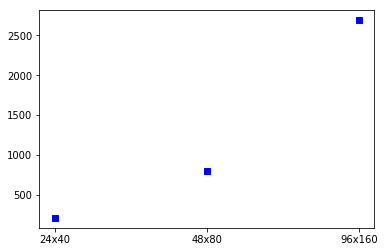

In [26]:
# compare network training and clustering speed
# training_time_arr

x_axis = ['24x40','48x80', '96x160']
y_axis = training_time_arr

plt.plot(x_axis, y_axis, 'bs')
plt.show()



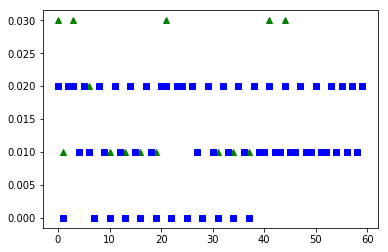

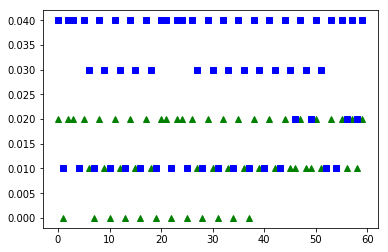

In [27]:
# we want to do a comparison in training speed

def draw_filter_training_speed(union_):
    x_axis = []
    y_axis1 = []
    y_axis2 = []
    curr_num = 0
    for i in range(len(union_)):
        if -1 in union_[i]:
            continue
        else:
            x_axis.append(curr_num)
            y_axis1.append(union_[i][1])
            y_axis2.append(union_[i][3])
            curr_num += 1

    plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
    plt.show()

for i in range(len(union_arr)):
    draw_filter_training_speed(union_arr[i])
    


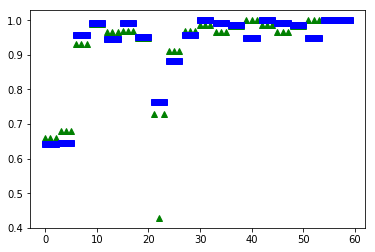

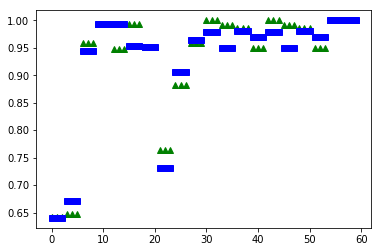

In [28]:
# we want to do a comparison in evaluation accuracy

def draw_filter_accuracy(union_):
    x_axis = []
    y_axis1 = []
    y_axis2 = []
    curr_num = 0
    for i in range(len(union_)):
        if -1 in union_[i]:
            continue
        else:
            x_axis.append(curr_num)
            y_axis1.append(union_[i][0])
            y_axis2.append(union_[i][2])
            curr_num += 1

    plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
    plt.show()
    
for i in range(len(union_arr)):
    union_ = union_arr[i]
    draw_filter_accuracy(union_)

In [29]:
#Comparison for only non random rows

def create_union_nonrandom(stats_arr, stats_arr_rep, row_names, row_names_rep):

    union_1 = np.zeros(shape = (len(row_names),4 ))

    index = 0
    new_row_names = []
    for idx,row_name in enumerate(row_names):
        if ("t=" in row_name) or ("s=" in row_name):
            union_1[index,0] = stats_arr[idx][0]
            union_1[index,1] = stats_arr[idx][1]
            new_row_names.append(row_name)
            if row_name not in row_names_rep:
                union_1[index, 2] = -1
                union_1[index, 3] = -1
            else:
                corresponding_idx = row_names_rep.index(row_name)
                union_1[index,2] = stats_arr_rep[corresponding_idx][0]
                union_1[index,3] = stats_arr_rep[corresponding_idx][1]
            index += 1

    
    return union_1

union_1_arr = []

for i in range(len(size_array) - 1):
    union_1 = create_union_nonrandom(stats_arr_rep_arr[i], stats_arr_rep_arr[i+1], row_names_arr[i], row_names_arr[i+1])
    union_1_arr.append(union_1)
    



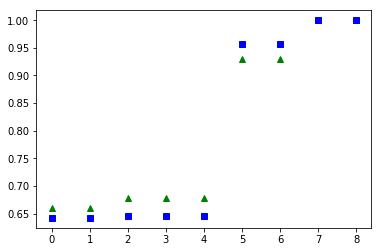

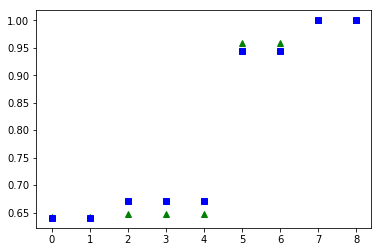

In [31]:
# we want to do a comparison in evaluation accuracy

def draw_accuracy_non_random(union_1):
    x_axis = []
    y_axis1 = []
    y_axis2 = []
    curr_num = 0
    for i in range(len(union_1)):
        if -1 in union_1[i]:
            continue
        elif 0 in union_1[i]:
            continue
        else:
            x_axis.append(curr_num)
            y_axis1.append(union_1[i][0])
            y_axis2.append(union_1[i][2])
            curr_num += 1

    plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
    plt.show()
    
for i in range(len(union_1_arr)):
    draw_accuracy_non_random(union_1_arr[i])

In [32]:
def print_analysis(union_, union_1, prev, curr):
    print("------------------------------")
    union_formatted = union_[1:, :]
    avg_speed_original = sum(union_formatted[:, 1]) / len(union_formatted[:,1])
    avg_speed_new = sum(union_formatted[:, 3]) / len(union_formatted[:,3])

    print("avg time for",prev,"pipeline", round(avg_speed_original,3), "seconds")
    print("avg time for",curr,"pipeline", round(avg_speed_new,3), "seconds")
    print(curr," pipeline is", round(avg_speed_original / avg_speed_new,3), "times faster")
    avg_accuracy_original = sum(union_formatted[:,0]) / len(union_formatted[:,0])
    avg_accuracy_new = sum(union_formatted[:,2]) / len(union_formatted[:,2])
    print("avg accuracy for",prev,"pipeline", round(avg_accuracy_original,3), "%")
    print("avg accuracy for",curr,"pipeline", round(avg_accuracy_new,3), "%")
    print("avg accuracy for",curr," is ", round(avg_accuracy_original - avg_accuracy_new,3),"worse than",prev," (Note if negative, it means it is better!)")

    union_formatted2 = union_1[1:12,:]
    avg_accuracy_original_ = sum(union_formatted2[:,0]) / len(union_formatted2[:,0])
    avg_accuracy_new_ = sum(union_formatted2[:,2]) / len(union_formatted2[:,2])
    print("avg accuracy for non random columns of",prev," pipeline", round(avg_accuracy_original_,3), "%")
    print("avg accuracy for non random columns of",curr," pipeline", round(avg_accuracy_new_,3), "%")
    print("avg accuracy for",curr," is ", round(avg_accuracy_original_ - avg_accuracy_new_,3),"worse than",prev, " (Note if negative, it means it is better!)")
    
x_axis = ['24x40','48x80', '96x160']
for i in range(len(union_arr)):
    print_analysis(union_arr[i], union_1_arr[i], x_axis[i],x_axis[i+1])

    

------------------------------
avg time for 24x40 pipeline 0.014 seconds
avg time for 48x80 pipeline 0.012 seconds
48x80  pipeline is 1.183 times faster
avg accuracy for 24x40 pipeline 0.931 %
avg accuracy for 48x80 pipeline 0.934 %
avg accuracy for 48x80  is  -0.003 worse than 24x40  (Note if negative, it means it is better!)
avg accuracy for non random columns of 24x40  pipeline 0.741 %
avg accuracy for non random columns of 48x80  pipeline 0.736 %
avg accuracy for 48x80  is  0.005 worse than 24x40  (Note if negative, it means it is better!)
------------------------------
avg time for 48x80 pipeline 0.012 seconds
avg time for 96x160 pipeline 0.028 seconds
96x160  pipeline is 0.436 times faster
avg accuracy for 48x80 pipeline 0.934 %
avg accuracy for 96x160 pipeline 0.93 %
avg accuracy for 96x160  is  0.004 worse than 48x80  (Note if negative, it means it is better!)
avg accuracy for non random columns of 48x80  pipeline 0.736 %
avg accuracy for non random columns of 96x160  pipeline 

In [35]:
a = [1,2,3,4,5]
print(a[1:3])

[2, 3]
